### Binary classification of sheared MNIST images
Reference: https://arxiv.org/abs/2201.10590

In [1]:
#Import required packages
import numpy as np
import matplotlib.pyplot as plt
import ot
import sys
import math
import os
import scipy.io as sio
import seaborn as sns
from scipy.io import savemat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Import custom back-bone python scripts
import Gaussians
import MNIST_LOT 

2022-02-18 09:08:33.056863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-18 09:08:33.056910: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Import MNIST images corresponding to all 10 digits
Images_X = []
Images_Y = []

for i in range(0,10):
    tmp_X = []
    tmp_Y = []
    MNIST_LOT.ImportImages(tmp_X,tmp_Y,i)    
    Images_X.append(tmp_X)
    Images_Y.append(tmp_Y)

n_max = np.empty(10)
for i in range(0,10):
    Images_X[i] = np.asarray(Images_X[i])
    [n_max[i], size_x, size_y] = Images_X[i].shape
print(n_max)

#Number of shears for each class
n_shears = 500
if n_shears > np.amin(n_max):
    print("The number of sheared images to be created exceeds the total number of unique images available")

#Set max and min values for shear parameters. 
lambd_min = 0.5
lambd_max = 1.5
shft_min = -5
shft_max = 5

Pixels = []
PointClouds = []
Masses = []
Labels = []

#Shear Images (might take a while depending on n_shears)
for i in range(0,10):
    print(i)
    
    #Shear n_shears images of type i and extract point cloud and masses
    Pixels_tmp = np.empty([n_shears,size_x*size_y])
    PointClouds_tmp, Masses_tmp = {}, {}

    MNIST_LOT.ShearImages(Images_X[i],PointClouds_tmp,Masses_tmp,Pixels_tmp,n_shears,lambd_min,lambd_max,shft_min,shft_max)

    Pixels.append(Pixels_tmp)
    PointClouds.append(PointClouds_tmp)
    Masses.append(Masses_tmp)
    Labels.append(np.asarray(Images_Y[i],dtype=int))
    

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
0
1
2
3
4
5
6
7
8
9


In [3]:
#Choose images from class1 and class2
img1 = 7
img2 = 9
N_total = n_shears

#Define references. Options are "true (even number of references)", "sheared (even number of references)", "Gaussian (1 or 5)"
n_ref = 2
ref_type = "true"

#Collect reference pool
ReferencePoolClass1 = []
tmpY1 = []
ReferencePoolClass2 = []
tmpY2 = []
MNIST_LOT.ImportImages(ReferencePoolClass1,tmpY1,img1)    
MNIST_LOT.ImportImages(ReferencePoolClass2,tmpY2,img2)    
del tmpY1, tmpY2

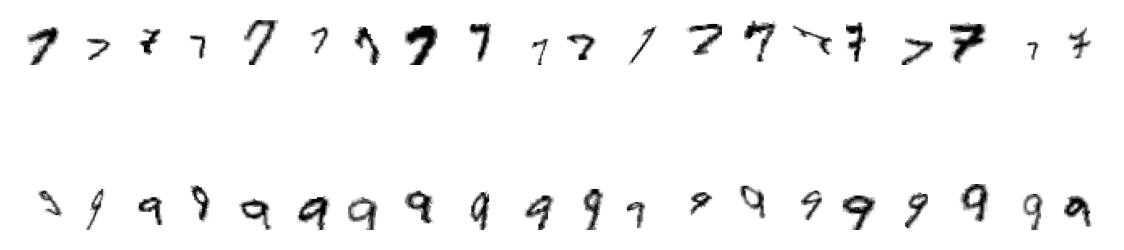

In [4]:
#Visualize samples of sheared images under chosen parameters
plt.rcParams["figure.figsize"] = (7,2)
plt.rcParams["figure.dpi"] = 200

tot_im = 20
for i in range(tot_im):
    
    idx = np.random.randint(0,N_total)
    
    #Show original image
    plt.subplot(2, tot_im, i+1)
    plt.imshow(Pixels[img1][idx].reshape(28,28), cmap='Greys')
    plt.axis('off')

    plt.subplot(2, tot_im, tot_im+1+i)
    plt.imshow(Pixels[img2][idx].reshape(28,28), cmap='Greys')
    plt.axis('off')

In [5]:
grid_size = 28
x = np.linspace(0,grid_size-1,grid_size)
y = np.linspace(0,grid_size-1,grid_size)
num_gridPoints = range(0,grid_size)
grid_points=[]
for i in range(0,grid_size):
    for j in range(0,grid_size):
        grid_points.append([x[i], y[j]])
grid_points = np.asarray(grid_points)

#Mean and covariance for a Gaussian reference distribution
if ref_type == "Gaussian":
    if n_ref == 1:
        mu = np.array([(grid_size-1)/2, (grid_size-1)/2])
        sigma = 3
        cov = pow(sigma,2)*np.identity(2)
        GaussianSamples, GaussianReference = Gaussians.DiscreteGaussian(mu,cov,x,y,grid_size,10000)
    elif n_ref == 5:
        mu_center = np.array([(grid_size-1)/2, (grid_size-1)/2])
        cov_center = pow(3,2)*np.identity(2)
        mu_1 = mu_center + np.array([-(grid_size-1)/3, -(grid_size-1)/3])
        mu_2 = mu_center + np.array([-(grid_size-1)/3, (grid_size-1)/3])
        mu_3 = mu_center + np.array([(grid_size-1)/3, -(grid_size-1)/3])
        mu_4 = mu_center + np.array([(grid_size-1)/3, (grid_size-1)/3])
        cov = pow(2,2)*np.identity(2)
        GaussianSamples_center, GaussianReference_center = Gaussians.DiscreteGaussian(mu_center,cov_center,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_sw = Gaussians.DiscreteGaussian(mu_1,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_nw = Gaussians.DiscreteGaussian(mu_2,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_se = Gaussians.DiscreteGaussian(mu_3,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_ne = Gaussians.DiscreteGaussian(mu_4,cov,x,y,grid_size,10000)        

if n_ref == 5 and ref_type == "Gaussian":
    fig, ax = plt.subplots(1,1)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_center)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_sw)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_nw)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_se)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_ne)
    ax.set_xlim([0,grid_size-1])
    ax.set_ylim([0,grid_size-1])
    ax.set_xticks(num_gridPoints)
    ax.set_yticks(num_gridPoints)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.tick_params(labelbottom=False)    
    ax.tick_params(labelleft=False) 
    #ax.set(title="Five Gaussian references")
    #plt.savefig("Images/Gaussianref5.png",bbox_inches="tight",facecolor="w",dpi=500)
elif n_ref == 1 and ref_type == "Gaussian":
    fig, ax = plt.subplots(1,1)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference)
    #ax.set_title("Single Gaussian reference",fontweight="bold")
    ax.set_xlim([0,grid_size-1])
    ax.set_ylim([0,grid_size-1])
    ax.set_xticks(num_gridPoints)
    ax.set_yticks(num_gridPoints)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.tick_params(labelbottom=False)    
    ax.tick_params(labelleft=False) 
    #plt.savefig("Images/Gaussianref1.png",bbox_inches="tight",facecolor="w",dpi=500)

In [6]:
#Squared Euclidean Cost matrix between the grid points
Cost = ot.dist(grid_points, grid_points, metric = "sqeuclidean")

reference = np.empty((n_ref,grid_size**2))

#Select reference images for "true" and "sheared" types
if ref_type != "Gaussian":
    for i in range(0,int(n_ref/2)):
        tmp_indx = np.random.randint(N_total-25,N_total)
        if ref_type == "true":
            reference[i] = ReferencePoolClass1[tmp_indx].flatten()
        elif ref_type == "sheared":        
            reference[i] = Pixels[img1][tmp_indx]
        reference[i] = (1/np.sum(reference[i]))*reference[i]
        
    for i in range(0,int(n_ref/2)):
        tmp_indx = np.random.randint(N_total-25,N_total)
        if ref_type == "true":
            reference[int(n_ref/2)+i] = ReferencePoolClass2[tmp_indx].flatten()
        elif ref_type == "sheared":
            reference[int(n_ref/2)+i] = Pixels[img2][tmp_indx]
        reference[int(n_ref/2)+i] = (1/np.sum(reference[int(n_ref/2)+i]))*reference[int(n_ref/2)+i]

elif ref_type == "Gaussian":
    if n_ref == 1:
        reference[0] = GaussianReference
    elif n_ref == 5:
        reference[0] = GaussianReference_center
        reference[1] = GaussianReference_sw
        reference[2] = GaussianReference_nw
        reference[3] = GaussianReference_se
        reference[4] = GaussianReference_ne
    for i in range(0,n_ref):
        reference[i] = (1/np.sum(reference[i]))*reference[i]


In [7]:
#Embed the sheared MNIST images corresponding to chosen reference
EmbeddingClass1 = []
EmbeddingClass2 = []

for i in range(0,N_total):
    template = Pixels[img1][i]
    template = (1/np.sum(template))*template
        
    Embedding, Support = MNIST_LOT.FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
   
    for j in range(1,n_ref):
        tmp1, tmp2 = MNIST_LOT.FullDiscreteEmbed(template,reference[j],Cost,grid_size)
        Embedding = np.concatenate((Embedding,tmp1),axis=0)
        Support = np.concatenate((Support,tmp2),axis=0)
        del tmp1, tmp2

    EmbeddingClass1.append(Embedding)
    
for i in range(0,N_total):
    template = Pixels[img2][i]
    template = (1/np.sum(template))*template
        
    Embedding, Support = MNIST_LOT.FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
   
    for j in range(1,n_ref):
        tmp1, tmp2 = MNIST_LOT.FullDiscreteEmbed(template,reference[j],Cost,grid_size)
        Embedding = np.concatenate((Embedding,tmp1),axis=0)
        Support = np.concatenate((Support,tmp2),axis=0)
        del tmp1, tmp2

    EmbeddingClass2.append(Embedding)    

print(2*int(Support.shape[0]))

602


5
10
15
20
40
60
80
100


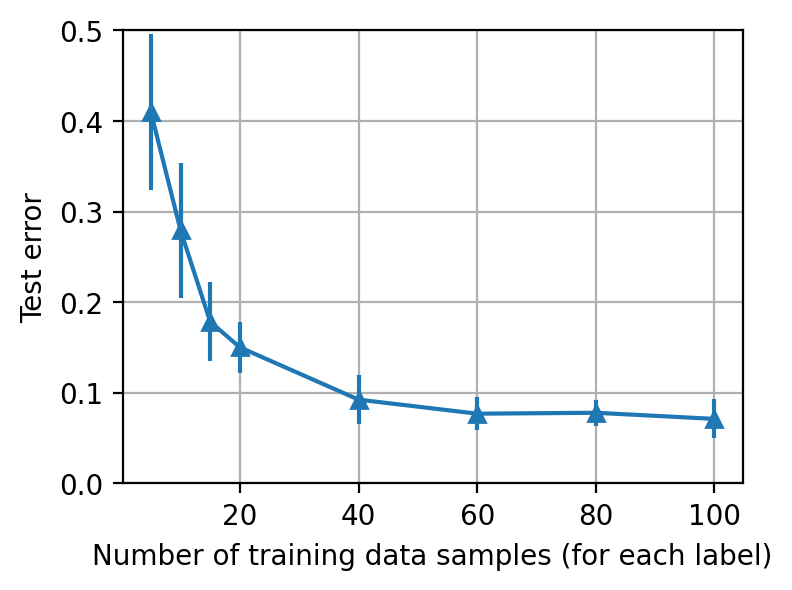

In [8]:
#Perform classsification tests using LDA
N_trainList = [5,10,15,20,40,60,80,100]
N_test  = 100
SdOTmean_list = []
SdOTstd_list = []

#Number of experiments
n_exp = 20

for j in range(0,len(N_trainList)):
    
    #Training set size (for each class)
    N_train = N_trainList[j]
    print(N_train)
    
    feature_vector = np.empty([2*N_train,2*len(Support)])
    label_vector = np.empty([2*N_train])
    tmp_list = np.empty(n_exp)

    for p in range(0,n_exp):
        
        #Choose training and testing images randomly
        index_list = np.random.permutation(np.arange(N_total-25))

        for i in range(0,N_train):

            feature_vector[2*i] = EmbeddingClass1[index_list[i]].flatten()
            label_vector[2*i] = Labels[img1][index_list[i]]  

            feature_vector[2*i+1] = EmbeddingClass2[index_list[i]].flatten()
            label_vector[2*i+1] = Labels[img2][index_list[i]] 

        clf = LinearDiscriminantAnalysis()
        clf.fit(feature_vector, label_vector)

        test_vector = np.empty([2*N_test,2*len(Support)])
        test_trueLabel = np.empty([2*N_test])
        
        for q in range(0,N_test):
            test_vector[2*q] = EmbeddingClass1[index_list[N_train+q]].flatten()
            test_trueLabel[2*q] = Labels[img1][index_list[N_train+q]] 

            test_vector[2*q+1] = EmbeddingClass2[index_list[N_train+q]].flatten()
            test_trueLabel[2*q+1] = Labels[img2][index_list[N_train+q]] 

        test_output = clf.predict(test_vector)    

        error_count = 0
        for m in range(0,N_test):
            if test_output[2*m] != test_trueLabel[2*m]:
                error_count = error_count + 1
            if test_output[2*m+1] != test_trueLabel[2*m+1]:
                error_count = error_count + 1

        tmp_list[p] = error_count/(2*N_test)

    SdOTmean_list.append(np.mean(tmp_list))
    SdOTstd_list.append(np.std(tmp_list))


plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["figure.dpi"] = 200
fig,ax = plt.subplots(1,1)

ax.set(xlabel="Number of training data samples (for each label)",ylabel="Test error")
ax.set_ylim([0, 0.5])
ax.errorbar(N_trainList,SdOTmean_list,SdOTstd_list,marker='^')
ax.grid()

[]

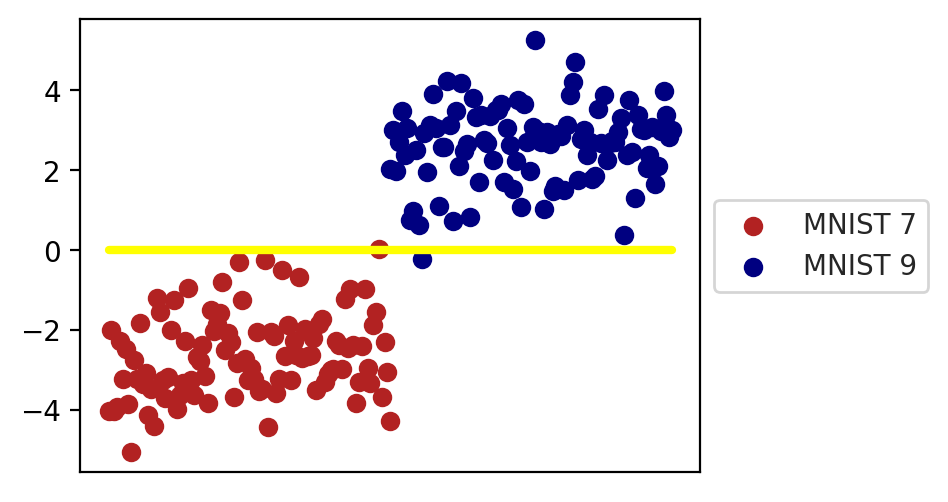

In [9]:
#Visualize LDA separation between classes
fig, ax = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams["figure.dpi"] = 200
sns.set_style("white")

Proj = clf.fit(feature_vector, label_vector).transform(feature_vector)

even_indices = range(0,2*N_train,2)
odd_indices = range(1,2*N_train,2)

x = np.linspace(0,int(0.5*len(feature_vector)),int(0.5*len(feature_vector)))
ax.scatter(x,Proj[even_indices,0],color="firebrick")
x = np.linspace(int(0.5*len(feature_vector)),len(feature_vector),int(0.5*len(feature_vector)))
ax.scatter(x,Proj[odd_indices,0],color="navy")

x = np.linspace(0,len(feature_vector),len(feature_vector))
zero_line = np.zeros(x.size)
ax.plot(x,zero_line,color="yellow",linewidth=3)

ax.set(xlabel="", ylabel="")
ax.legend(["MNIST " + str(img1),"MNIST " + str(img2)],loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks([])